In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import random
import time
import scipy.sparse as sp
from tqdm import tqdm

from helpers import generate_embedding
from graph_alignment import *

# Example code to run alignment

Note that to run the below code verbatim, you would first need to obtain the data from $\href{https://github.com/constantinosskitsas/Framework_GraphAlignment/blob/master/data.zip}{https://github.com/constantinosskitsas/Framework_GraphAlignment/blob/master/data.zip}$

In [2]:
def one_way_noise(original_graph, x = 1):
    # Get the list of nodes in the grap
    graph = original_graph.copy()
    nodes = list(graph.nodes)
    edges = list(graph.edges)
    # Calculate number of pairs to randomize based on the percentage
    num_pairs_to_remove = int(len(edges) * x / 100)
    
    # Generate random pairs of nodes (without repetition) and exclude self-loops
    pairs_to_remove = []
    while len(pairs_to_remove) < num_pairs_to_remove:
        u, v = list(graph.edges)[np.random.choice(len(graph.edges), replace=False)]
        if graph.degree(u) != 1 and graph.degree(v) != 1:
            pairs_to_remove.append((u, v))
            graph.remove_edge(u, v)
    
    return graph

def plant_alignment(graph):
    if graph.is_directed():
        print(graph.is_directed())
        G_ = nx.DiGraph()
    else:
        G_ = nx.Graph()
    N = len(graph.nodes)
    pi_star = np.random.permutation(N)
    mapping = dict(zip(np.arange(0, N), pi_star))

    G_.add_nodes_from(graph.nodes())
    G_.add_edges_from((mapping[u], mapping[v]) for u, v in graph.edges())
    return G_, mapping

def find_error(G1, G2, row, col):
    Pi = np.zeros((N, N), dtype=int)
    Pi[row, col] = 1
    A1, A2 = nx.adjacency_matrix(G1), nx.adjacency_matrix(G2)
    print('Hello1')
    A2_aligned = Pi @ A2 @ Pi.T
    print('Hello2')
    alignment_error = np.linalg.norm(A1 - A2_aligned, 'fro')
    return alignment_error

def calculate_alignment_accuracy(row, col, true_mapping):
    correct_count = 0
    N = len(row)
    for i in range(N):
        if (row[i], col[i]) in true_mapping.items():
            correct_count += 1

    # Calculate the fraction of correct alignments
    correct_fraction = correct_count / N
    
    return correct_fraction



# Benchmark over different extents of noise

In [46]:
def benchmark_over_noise(G_0, noise_fn, noises, n_graphs=10):
    n = len(noises)
    frt = np.zeros((n, 2, n_graphs))
    fugal = np.zeros((n, 2, n_graphs))
    fugal_frt = np.zeros((n, 2, n_graphs))

    for x in tqdm(range(n)):
        noisy_graphs = [] ; true_alignments = []
        for i in range(n_graphs):
            G = noise_fn(G_0, noises[x])
            G, mapping = plant_alignment(G)
            true_alignments.append(mapping)
            noisy_graphs.append(G)

        frt_accuracy = [] ;fugal_accuracy = [] ; fugal_frt_accuracy = []
        frt_time = [] ;  fugal_time = [] ; fugal_frt_time = []
        for i in range(n_graphs):
            row, col, t1 = FRTD_alignment(G_0, noisy_graphs[i], M=300, teleport=False, alpha=0.1, normalise_embedding=True, directed=False)
            frt_time.append(t1)
            #print('FRT done!')
            
            row3, col3, t1 = FUGAL_alignment(G_0, noisy_graphs[i], mu=1, use_normalised_adjacency=False, sink_method='sinkhorn')
            fugal_time.append(t1)
            #print('FUGAL done!')

            row4, col4, t1 = FUGAL_FRT_alignment(G_0, noisy_graphs[i], mu=1, use_normalised_adjacency=False, sink_method='sinkhorn',
                                                 M=300, teleport=False, alpha=0.1, normalise_embedding=True,
                                                metric='TVD')
            fugal_frt_time.append(t1)
            #print('FRT+FUGAL done!')
        
            frt_accuracy.append(calculate_alignment_accuracy(row, col, true_alignments[i]))
            fugal_accuracy.append(calculate_alignment_accuracy(row3, col3, true_alignments[i]))
            fugal_frt_accuracy.append(calculate_alignment_accuracy(row4, col4, true_alignments[i]))

        frt[x] = np.array(frt_accuracy), np.array(frt_time)
        fugal[x] = np.array(fugal_accuracy), np.array(fugal_time)
        fugal_frt[x] = np.array(fugal_frt_accuracy), np.array(fugal_frt_time)

    return frt, fugal, fugal_frt

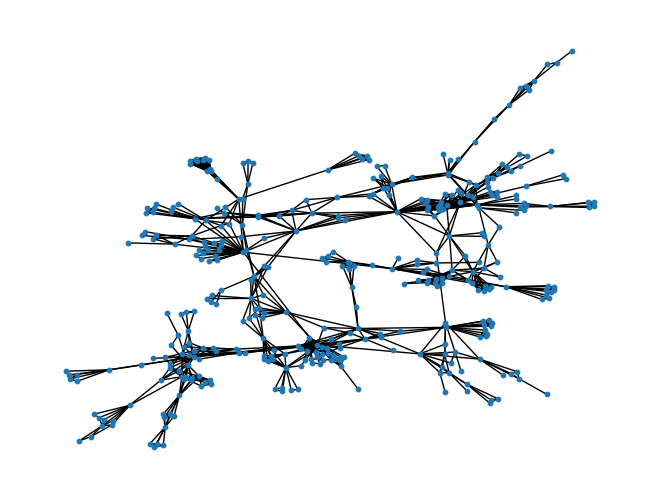

In [48]:
G_0 = nx.read_edgelist('Alignment_data/ca-netscience.txt')

G_0 = nx.convert_node_labels_to_integers(G_0, first_label=0)
N = len(G_0.nodes)

G_0.remove_edges_from(nx.selfloop_edges(G_0))

positions = nx.spring_layout(G_0)

#fig = plt.figure(figsize=(10, 10))
nx.draw(G_0, pos=positions, node_size=10, with_labels=False)

In [50]:
noises = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25]
#noises = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [52]:
frt, fugal, fugal_frt = benchmark_over_noise(G_0, one_way_noise, noises, n_graphs=10)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [01:01<09:15, 61.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

 20%|████████▊                                   | 2/10 [02:06<08:27, 63.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

 30%|█████████████▏                              | 3/10 [03:07<07:17, 62.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

 40%|█████████████████▌                          | 4/10 [04:08<06:11, 61.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

 50%|██████████████████████                      | 5/10 [05:10<05:09, 61.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████████████████████████▍                 | 6/10 [06:16<04:12, 63.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████████████████████████████▊             | 7/10 [07:23<03:13, 64.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████████████████████████████████▏        | 8/10 [08:24<02:06, 63.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

 90%|███████████████████████████████████████▌    | 9/10 [09:24<01:02, 62.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/vedantat/Desktop/DPhil Codes/FUGAL-FRT/helpers/sinkhorn.py:182: UserWarning: An output with one or more elements was resized since it had shape [379], which does not match the required output shape [1, 379]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.matmul(u, K, out=KTu)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 10/10 [10:29<00:00, 62.94s/it]


In [53]:
mean_frt = np.mean(frt, axis=2) ; std_frt = np.std(frt, axis=2)
mean_fugal = np.mean(fugal, axis=2) ; std_fugal = np.std(fugal, axis=2)
mean_fugal_frt = np.mean(fugal_frt, axis=2) ; std_fugal_frt = np.std(fugal_frt, axis=2)

(0.0, 1.0)

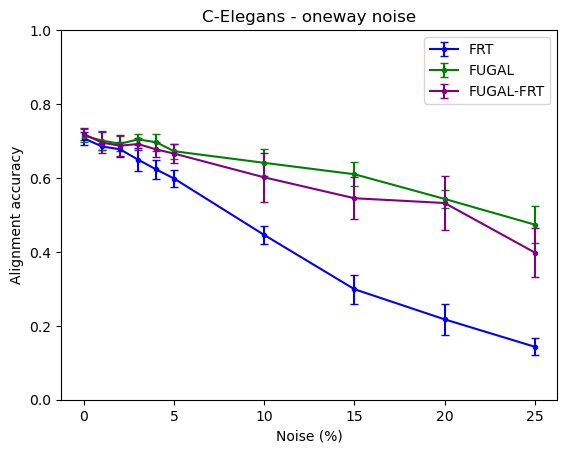

In [59]:
plt.errorbar(noises, mean_frt[:, 0], yerr = std_frt[:, 0], label='FRT', capsize=3, marker='.', color='b')
plt.errorbar(noises, mean_fugal[:, 0], yerr = std_fugal[:, 0], label='FUGAL', capsize=3, marker='.', color='g')
plt.errorbar(noises, mean_fugal_frt[:, 0], yerr = std_fugal_frt[:, 0], label='FUGAL-FRT', capsize=3, marker='.', color='purple')

plt.xlabel('Noise (%)')
plt.ylabel('Alignment accuracy')
plt.title('C-Elegans - oneway noise')
plt.legend()

plt.ylim(0, 1)

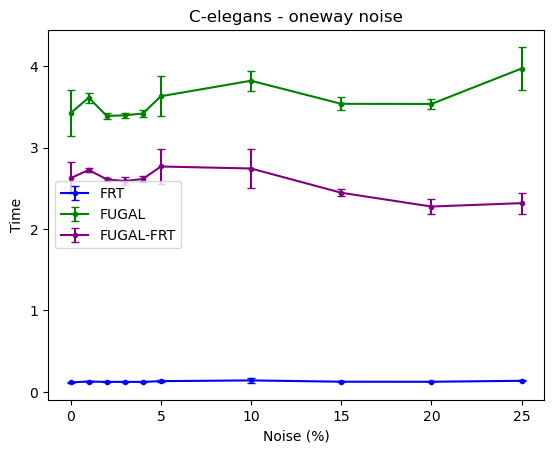

In [61]:
plt.errorbar(noises, mean_frt[:, 1], yerr = std_frt[:, 1], label='FRT', capsize=3, marker='.', color='b')
plt.errorbar(noises, mean_fugal[:, 1], yerr = std_fugal[:, 1], label='FUGAL', capsize=3, marker='.', color='g')
plt.errorbar(noises, mean_fugal_frt[:, 1], yerr = std_fugal_frt[:, 1], label='FUGAL-FRT', capsize=3, marker='.', color='purple')

plt.xlabel('Noise (%)')
plt.ylabel('Time')
plt.title('C-elegans - oneway noise')

plt.legend()

# Benchmark at fixed noise for multiple graphs


In [ ]:
def benchmark_fixed_noise(file, noise_fn, noise, n_graphs=10, real_noise_graph=None, edited_version=None, true_alignment=None):
    noisy_graphs = [] ; true_alignments = []
    if real_noise_graph is None:
        G_0 = nx.read_edgelist(file)
        G_0 = nx.convert_node_labels_to_integers(G_0, first_label=0)
        N = len(G_0.nodes)
        G_0.remove_edges_from(nx.selfloop_edges(G_0))
        for i in range(n_graphs):
            G = noise_fn(G_0, noise=noise)
            G, mapping = plant_alignment(G)
            true_alignments.append(mapping)
            noisy_graphs.append(G)
    else:
        n_graphs=1
        G_0 = real_noise_graph
        noisy_graphs.append(edited_version)
        true_alignments.append(true_alignment)

    frt_accuracy = [] ; faq_accuracy = [] ; fugal_accuracy = [] ; fugal_frt_accuracy = []
    frt_time = [] ; faq_time = [] ; fugal_time = [] ; fugal_frt_time = []
    for i in range(n_graphs):
        row, col, t1 = FRTD_alignment(G_0, noisy_graphs[i], M=300, teleport=False, alpha=0.1, normalise_embedding=True, directed=False)
        frt_time.append(t1)
        #print('FRT done!')
        
        row3, col3, t1 = FUGAL_alignment(G_0, noisy_graphs[i], mu=1, use_normalised_adjacency=False, sink_method='sinkhorn')
        fugal_time.append(t1)
        #print('FUGAL done!')

        row4, col4, t1 = FUGAL_FRT_alignment(G_0, noisy_graphs[i], mu=1, use_normalised_adjacency=False, sink_method='sinkhorn',
                                             M=300, teleport=False, alpha=0.1, normalise_embedding=True,
                                            metric='TVD')
        fugal_frt_time.append(t1)
        #print('FRT+FUGAL done!')

        frt_accuracy.append(calculate_alignment_accuracy(row, col, true_alignments[i]))
        fugal_accuracy.append(calculate_alignment_accuracy(row3, col3, true_alignments[i]))
        fugal_frt_accuracy.append(calculate_alignment_accuracy(row4, col4, true_alignments[i]))

    return frt_accuracy, frt_time, fugal_accuracy, fugal_time, fugal_frt_accuracy, fugal_frt_time



In [ ]:
frt = np.zeros((14, 4))
fugal = np.zeros((14, 4))
fugal_frt = np.zeros((14, 4))

In [ ]:
labels = ['ca-netscience', 'inf-euroroad', 'bio-celegans', 'in-arenas', 'inf-power', 'ca-Erdos992', 'ca-GrQc', 'soc-hamsterster', 'bio-dmela',
         'socfb-Haverford76', 'socfb-Swarthmore42', 'socfb-Bowdoin47', 'soc-facebook', 'socfb-Hamilton46']

for j in range(len(labels)):
    print(j)
    file = f'Alignment_data/{labels[j]}.txt'
    frt_accuracy, frt_time, fugal_accuracy, fugal_time, fugal_frt_accuracy, fugal_frt_time = \
    benchmark_fixed_noise(file,
                          noise_fn = one_way_noise,
                          noise = 5,
                          n_graphs=5,
                          real_noise_graph=None,
                          edited_version = None)

    frt[j, :] = np.mean(frt_accuracy), np.std(frt_accuracy), np.mean(frt_time), np.std(frt_time)
    fugal[j, :] = np.mean(fugal_accuracy), np.std(fugal_accuracy), np.mean(fugal_time), np.std(fugal_time)
    fugal_frt[j, :] = np.mean(fugal_frt_accuracy), np.std(fugal_frt_accuracy), np.mean(fugal_frt_time), np.std(fugal_frt_time)
    

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.errorbar(np.arange(14), frt[:, 0], yerr = frt[:, 1], fmt='^', color='b', label='FRT', capsize=3, markersize=8)
plt.errorbar(np.arange(14), fugal[:, 0], yerr = fugal[:, 1], marker='o', color='g', label='FUGAL', capsize=3, markersize=12, linestyle='--')
plt.errorbar(np.arange(14), fugal_frt[:, 0], yerr = fugal_frt[:, 1], fmt='s', color='purple', label='FUGAL-FRT', capsize=3, markersize=12,  linewidth=3)


plt.xticks(np.arange(14), fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22, prop={'family':'serif', 'size':18})
plt.xlabel('Index', fontsize=23, font='serif') ; plt.ylabel('Accuracy', fontsize=23, font='serif')
plt.ylim(-0.1, 1.1)
plt.grid()





In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.errorbar(np.arange(14), frt[:, 2], yerr = frt[:, 3], fmt='^', color='b', label='FRT', capsize=3, markersize=8)
plt.errorbar(np.arange(14), fugal[:, 2], yerr = fugal[:, 3], marker='o', color='g', label='FUGAL', capsize=3, markersize=12, linestyle='--')
plt.errorbar(np.arange(14), fugal_frt[:, 2], yerr = fugal_frt[:, 3], fmt='s', color='purple', label='FUGAL-FRT', capsize=3, markersize=12,  linewidth=3)


plt.xticks(np.arange(14), fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22, prop={'family':'serif', 'size':18})
plt.xlabel('Index', fontsize=23, font='serif') ; plt.ylabel('Time', fontsize=23, font='serif')
#plt.ylim(-0.1, 1.1)
plt.yscale('log')
plt.grid()

